In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from statsmodels.api import OLS
import yfinance as yf

In [28]:
eusa = pd.read_excel('excel_data/EUSA.xlsx')
eusa.drop(columns=['Unnamed: 0'], inplace=True)
eusa.rename(columns={'Net Asset Value': 'NAV', 'Last Price': 'Close'}, inplace=True)
eusa.dropna(inplace=True)
"""
Dropping nulls might mess up the analysis, but it seems like a safer option
compared to filling with the average of the previous and next values (as
doing so would add fake predictivity)
"""
eusa.head()

,Date,NAV,Close
1,2023-01-19,74.9908,75.00
2,2023-01-18,75.8862,75.91
3,2023-01-17,77.0371,77.07
5,2023-01-13,77.0854,77.09
6,2023-01-12,76.8496,76.86


In [64]:
# Find the index where the Date is equal to 2022-03-31
eusa[eusa['Date'] == '2022-03-31'].index[0]

211

Calculating the spread between the close and NAV and plotting the rolling bollinger bands.

In [48]:
""" Spread """
spread = (eusa['Close'] / eusa['NAV']) - 1

""" Z-Score (deviations from mean required to trigger an entry) """
zs = 1.5

""" Bollinger Bands """
# Calculate the upper and lower bollinger bands and the rolling mean
bollinger_mean = spread.rolling(window=20).mean()
bollinger_std = spread.rolling(window=20).std()
upper_bollinger_bands = bollinger_mean + (bollinger_std * zs)
lower_bollinger_bands = bollinger_mean - (bollinger_std * zs)

In [68]:
print(upper_bollinger_bands[211])
print(lower_bollinger_bands[211])

0.0009272468775579709
-0.0005987506767878478


In [52]:
print(f'last upper band: {upper_bollinger_bands.iloc[-1]}')
print(f'last lower band: {lower_bollinger_bands.iloc[-1]}')
print(f'last spread: {float(spread.tail(1))}')

last upper band: 0.005875783283785719
last lower band: -0.005351882236043315
last spread: 0.000689179875947632


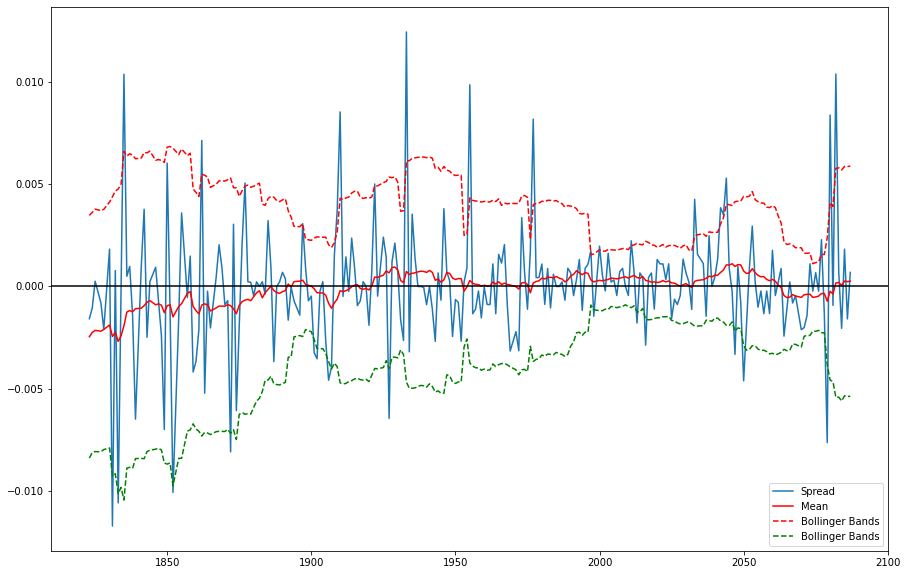

In [49]:
""" Plot """
plt.figure(figsize=(15, 10))
plt.plot(spread[len(spread) - 252:], label='Spread')
plt.plot(bollinger_mean[len(spread) - 252:], label='Mean', color='red')
plt.plot(upper_bollinger_bands[len(spread) - 252:], label='Bollinger Bands', color='red', linestyle='--')
plt.plot(lower_bollinger_bands[len(spread) - 252:], label='Bollinger Bands', color='green', linestyle='--')
# Put a line at 0
plt.axhline(0, color='black')
plt.legend()
plt.show()

### Isolating a stable-beta pair to trade in place of EUSA NAV

### Calculating the hedge ratio between EUSA NAV and the aforementioned replacement security

In [26]:
# Get another dataframe that is only for the dates past 2022-01-01
eusa_recent = eusa[eusa['Date'] > '2020-01-01']
# convert to a dictionary
eusa_recent_dict = eusa_recent.to_dict('list')
#print(eusa_recent_dict)

In [12]:
# read in the eusa_dict as a dataframe
eusa_recent_df = pd.DataFrame(eusa_recent_dict)
eusa_recent_df.head()

,Date,NAV,Close
0,2023-01-19,74.9908,75.00
1,2023-01-18,75.8862,75.91
2,2023-01-17,77.0371,77.07
3,2023-01-13,77.0854,77.09
4,2023-01-12,76.8496,76.86


In [4]:
print(f'Number of entries: {len(eusa)}')

Number of entries: 2000


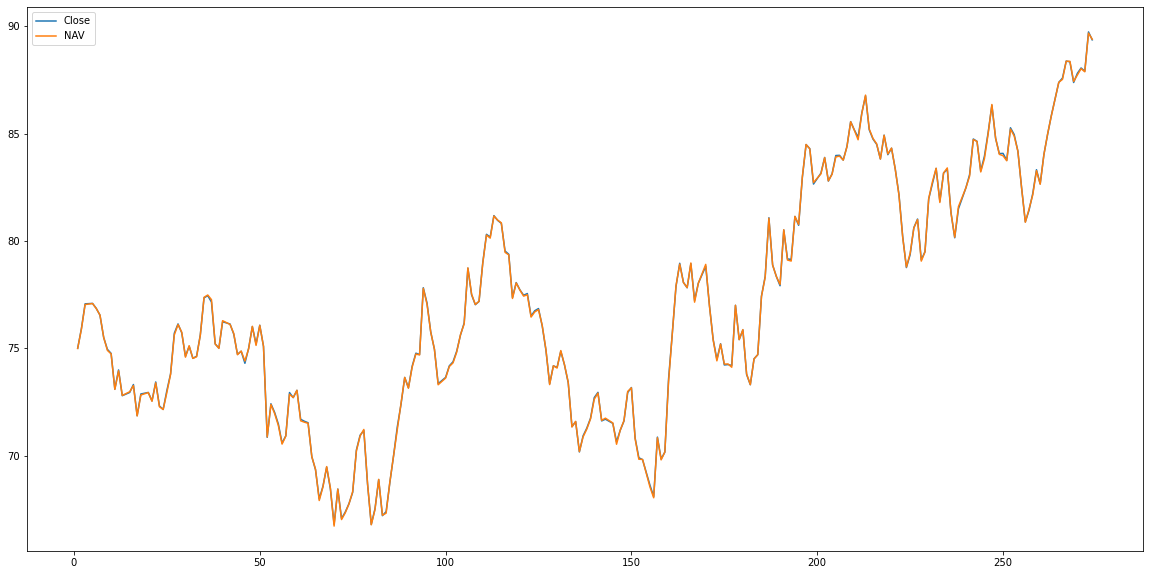

In [5]:
# Plot the value of the close and the NAV for the years 2021 - 2023 make the chart big
recent_eusa = eusa[eusa['Date'] > '2022-01-01']
plt.figure(figsize=(20, 10))
plt.plot(recent_eusa['Close'], label='Close')
plt.plot(recent_eusa['NAV'], label='NAV')
plt.legend()
plt.show()

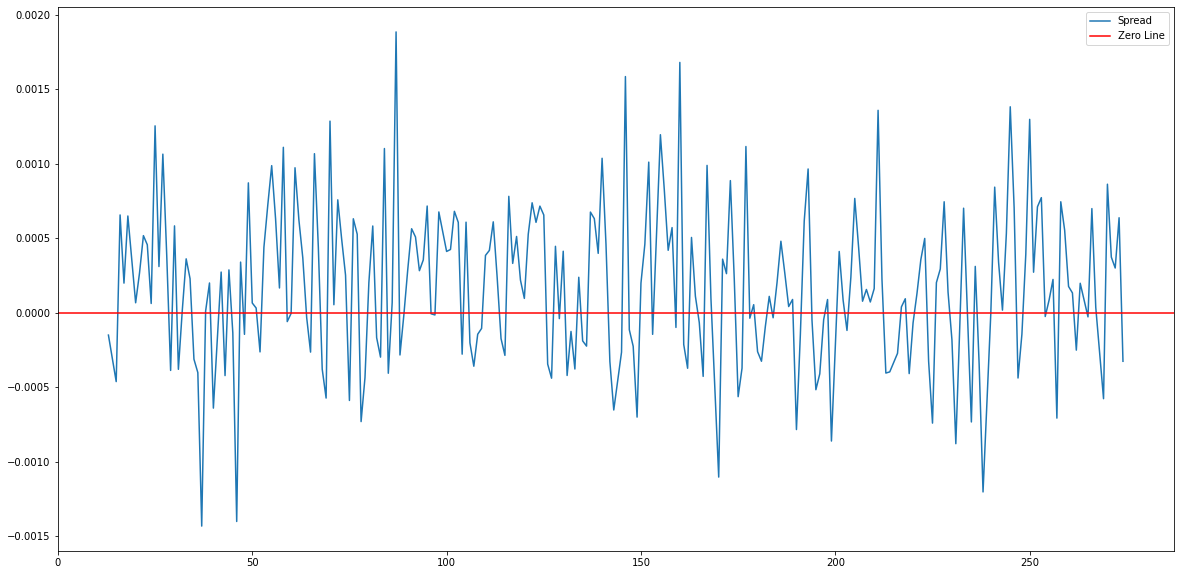

In [13]:
# Spread = (Close/NAV) - 1
spread = (eusa['Close']/eusa['NAV']) - 1
plt.figure(figsize=(20, 10))
plt.plot(spread[len(spread) - 252:], label='Spread')
plt.axhline(0, color='red', label='Zero Line')
plt.legend()
plt.show()

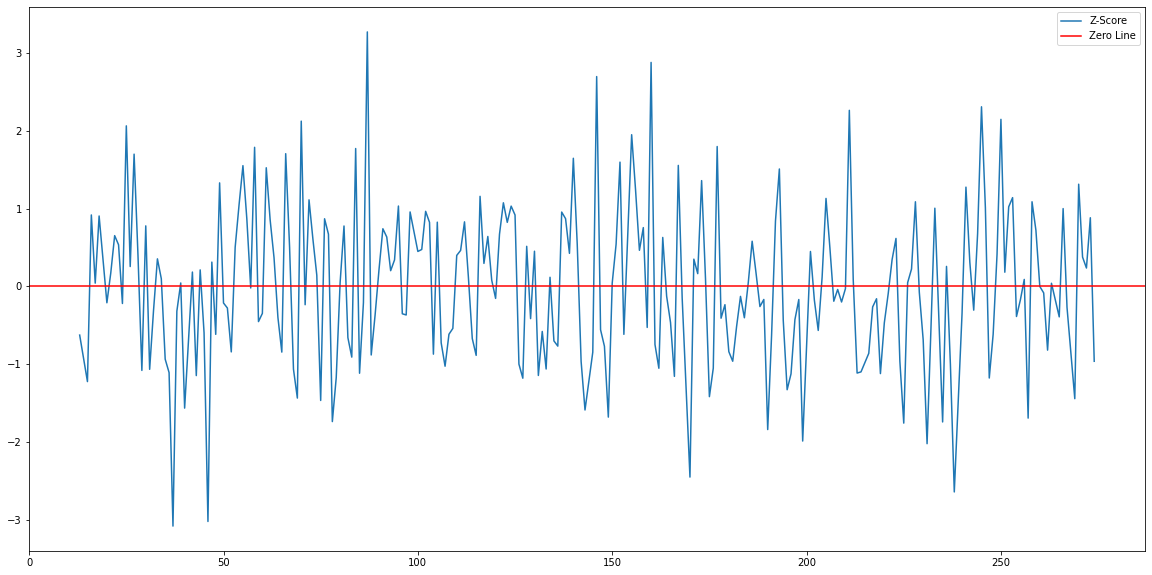

In [23]:
# Get the z score
zscore = (spread - spread.mean())/spread.std()
plt.figure(figsize=(20, 10))
plt.plot(zscore[len(zscore) - 252:], label='Z-Score')
plt.axhline(0, color='red', label='Zero Line')
plt.legend()

In [7]:
# coint_t: Cointegration test statistic (t-statistic) for the null hypothesis that the two series are not cointegrated.
# pvalue: MacKinnon's approximate p-value
# crit_value: Critical values for the test statistic at the 1 %, 5 %, and 10 % levels.
coint_t, pvalue, crit_value = coint(
    eusa['Close'], eusa['NAV']
    )
print(f'cointegration test statistic: {coint_t}')
print(f'p-value: {pvalue}')
print(f'critical values: {crit_value}')

cointegration test statistic: -7.016538531996953
p-value: 7.83788280532478e-09
critical values: [-3.90192708 -3.33918829 -3.04657234]
